



<strong>
        <center><h4 style = "margin-right:60px"><font size = 6> Image Captioning-VAE</font></h4></center>
    </strong>
    
<br>
<br>
<br>
<font size=4>A novel variational autoencoder is developed to model images, as well as associated
labels or captions. The Deep Generative Deconvolutional Network (DGDN) is used
as a decoder of the latent image features, and a deep Convolutional Neural Network
(CNN) is used as an image encoder; the CNN is used to approximate a distribution
for the latent DGDN features/code. The latent code is also linked to generative
models for labels (Bayesian support vector machine) or captions (recurrent neural
network). When predicting a label/caption for a new image at test, averaging is
performed across the distribution of latent codes; this is computationally efficient as
a consequence of the learned CNN-based encoder. Since the framework is capable
of modeling the image in the presence/absence of associated labels/captions, a
new semi-supervised setting is manifested for CNN learning with images; the
framework even allows unsupervised CNN learning, based on images alone.</font>
<br>
<br>
<br>
<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>CONTENTS</font></h4>
    </strong>
</div><br>
<font size = 3.5 color = "blue">
<li>Importing Packages</li><br>
<li>Data Wrangling</li><br>
<li>Data Modelling</li><br>
<li>Encoder</li><br>
<li>Decoder</li><br>
<li>Image Captioner</li><br>
<li>VAE Captioner</li><br>
<li>Output Visualization</li><br>
<li>Evaluation Metrics</li><br>
</font>



<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>IMPORTING PACKAGES</font></h4>
    </strong>
</div><br>

In [1]:
# importing the packages
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm

import numpy as np
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>DATA WRANGLING</font></h4>
    </strong>
</div><br>

In [2]:
# wrangling the (image,caption ) format
class Data(Dataset):
    
    def __init__(self, root_file, captions, transform=None):
        
        self.transform = transform
        self.root = root_file
        self.ids = captions
        
    def __getitem__(self, idx):
        
        image_path, caption = self.ids[idx]
        image = Image.open(self.root+image_path)
        if self.transform: 
            image = self.transform(image)

        return image, caption
    
    def __len__(self):
        return self.ids.shape[0]
        
        

In [17]:
# Genrating vocabulary for our captioner 
def build_datasets_vocab(root_file, captions_file, transform, split=0.25):
    df = pd.read_csv(captions_file)
    
    vocab = {}
    def create_vocab(caption):
        tokens = [token.lower() for token in word_tokenize(caption)]
        for token in tokens: 
            if token not in vocab: 
                vocab[token] = len(vocab)
            
    df["caption"].apply(create_vocab)
    
    train, valid = train_test_split(df, test_size=split, random_state=42)
    return Data(root_file, train.values, transform), \
           Data(root_file, valid.values, transform), \
           vocab
    
        

In [18]:
# splitting the data into train and valid
def splitting_data():
    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
    ])
    train_dataset, valid_dataset, vocab = build_datasets_vocab("../input/flickr8k/Images/", 
                                                  "../input/flickr8k/captions.txt",
                                                  transform)

    id_to_word = {id_: word for word, id_ in vocab.items()}
    return train_dataset,valid_dataset,vocab,id_to_word
train_dataset,valid_dataset,vocab,id_to_word=splitting_data()

In [19]:
df = pd.read_csv("../input/flickr8k/captions.txt")
MAX_CAPTION_LEN = 38

In [20]:
# Transfomring the captions into desirable format
def transform_captions(captions):
    
    transformed = [[vocab[word.lower()] for word in word_tokenize(caption)] for caption in captions]
    padded = [transform + [vocab["."]]*(MAX_CAPTION_LEN - len(transform)) for transform in transformed]
    
    return padded

In [21]:
def get_caption(caption_sequence):
    
    return " ".join([id_to_word[id_] for id_ in caption_sequence if id_ != vocab["."]])

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>DATA MODELLING</font></h4>
    </strong>
</div><br>

In [22]:
# Convleak is used for downsampling the image 
class ConvLeak(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=5):
        
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.LeakyReLU(),
        )
        
    def forward(self, x):
        return self.layer(x)
    
 # ConvTransposeleak is used for upsampling the image back to original size 
class ConvTransposeLeak(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.LeakyReLU(),
        )
        
    def forward(self, x):
        return self.layer(x) 

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>ENOCDER</font></h4>
    </strong>
</div><br>

In [23]:
# encoder is used for getting the parameters of the distribution (ie) mean(Mu) and Standard deviation(sigma)

POOLING_FACTOR = 32
class Encoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, image_dim, latent_dim):
        
        super().__init__()
        
        # Some constants
        
        iW, iH = image_dim
        hW, hH = iW//POOLING_FACTOR, iH//POOLING_FACTOR
        vec_dim = out_channels * hW * hH
        
        self.layer1 = nn.Sequential(
            ConvLeak(in_channels=in_channels, out_channels=48),
            ConvLeak(in_channels=48, out_channels=48)
        )
        self.layer2 = nn.Sequential(
            ConvLeak(in_channels=48, out_channels=84),
            ConvLeak(in_channels=84, out_channels=84)
        )
        self.layer3 = nn.Sequential(
            ConvLeak(in_channels=84, out_channels=128),
            ConvLeak(in_channels=128, out_channels=128)
        )

        self.layer4 = nn.Sequential(
            ConvLeak(in_channels=128, out_channels=out_channels),
            nn.Flatten()
        )
        
        self.pooling = nn.MaxPool2d(4, return_indices=True)
        self.pooling_2 = nn.MaxPool2d(2, return_indices=True) 
        
        
        self.hidden = nn.Sequential(
            nn.Linear(in_features = vec_dim, out_features=latent_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.Tanh()
        )
            
        self.encoder_mean = nn.Linear(in_features = latent_dim, out_features = vec_dim)
        self.encoder_logstd = nn.Linear(in_features = latent_dim, out_features = vec_dim)

# Genrating the latent distribution with mean and standard deviation
        
    def generate_code(self, mean, log_std):
        
        sigma = torch.exp(log_std)
        epsilon = torch.randn_like(mean)
        return (sigma * epsilon) + mean 
# Forward function will return the convolution dimension and sampled latent vector   
        
    def forward(self, x):
        
        x = self.layer1(x)
        x, indices_1 = self.pooling(x)
        x = self.layer2(x)
        x, indices_2 = self.pooling(x)
        x = self.layer3(x)
        x, indices_3 = self.pooling_2(x)
        x = self.layer4(x)
        
        hidden = self.hidden(x)
        mean, log_std = self.encoder_mean(hidden), self.encoder_logstd(hidden)
        c = self.generate_code(mean, log_std)
        
        return c, indices_1, indices_2, indices_3, mean, log_std

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>DECODER</font></h4>
    </strong>
</div><br>

In [24]:
# Decoder will upsample to the original size of the image from latent vector
class Decoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, image_dim):
        
        super().__init__()
        
        iW, iH = image_dim
        hW, hH = iW//POOLING_FACTOR, iH//POOLING_FACTOR
        
        self.layer4 = nn.Sequential(
            nn.Unflatten(1, unflattened_size=(in_channels, hW, hH)),
            ConvTransposeLeak(in_channels=in_channels, out_channels=128)
        )
        

        self.layer3 = nn.Sequential(
            ConvTransposeLeak(128, 128),
            ConvTransposeLeak(128, 84)
        )
        self.layer2 = nn.Sequential(
            ConvTransposeLeak(84, 84),
            ConvTransposeLeak(84, 48)
        )
        self.layer1 = nn.Sequential(
            ConvTransposeLeak(48, 48),
            ConvTransposeLeak(48, 3)
        )
        
        self.unpooling = nn.MaxUnpool2d(4)
        self.unpooling_2 = nn.MaxUnpool2d(2)
        
        self.precision = nn.Parameter(torch.rand(1))
        
        
    def generate_data(self, mean, precision):
        
        # Precision is 1/variance
        sigma = torch.exp(-precision)
        epsilon = torch.randn_like(mean)
        return (sigma * epsilon) + mean
        
    def forward(self, x, indices_1, indices_2, indices_3):
        

        x = self.layer4(x)
        x = self.unpooling_2(x, indices_3)
        x = self.layer3(x)
        x = self.unpooling(x, indices_2)
        x = self.layer2(x)
        x = self.unpooling(x, indices_1)
        x = self.layer1(x)
        
        return x

        

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>CAPTIONER</font></h4>
    </strong>
</div><br>

In [25]:
# Captioner captions the image using the decoded latent vector from the Variational autoencoder
class CaptionRNN(nn.Module):
    
    CAPTION_LIMIT = MAX_CAPTION_LEN
    
    def __init__(self, input_size, vocab_size, embedding_size, hidden_size, stop_index):
        super().__init__()
        
        
        self.mlp_l1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=input_size),
            nn.LeakyReLU(),
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Tanh()
        )
        
        self.mlp_l2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_size, out_features=vocab_size),
        )
        

        
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        self.stop_index = stop_index
        
        
    def generate_caption(self, code):
        

        h_1 = self.mlp_l1(code)
        prob_1 = F.softmax(self.mlp_l2(h_1), dim=-1)
        y_1 = torch.multinomial(prob_1, 1)
        
        words = [y_1.item()]
        w_t = self.embedding(y_1)
        y_t = y_1
        h_t = h_1
        

        while len(words) < CaptionRNN.CAPTION_LIMIT and y_t.item() != self.stop_index:
            h_t = self.gru(w_t.unsqueeze(0), h_t.unsqueeze(0).unsqueeze(0))[0]
            h_t = h_t.squeeze(0).squeeze(0)
            prob_t = F.softmax(self.mlp_l2(h_t), dim=-1)
            y_t = torch.multinomial(prob_t, 1)
            words.append(y_t.item())
            w_t = self.embedding(y_t)
        
        return words
        
        
    def caption_prob(self, code, caption):
        hidden_1 = self.mlp_l1(code)
        probs_1 = F.softmax(self.mlp_l2(hidden_1), dim=1)
        weights = self.embedding(caption)
        output, hidden = self.gru(weights, hidden_1.unsqueeze(0))
        probs_2_above = F.softmax(self.mlp_l2(output[:, :-1]), dim=-1)
        return torch.cat([probs_1.unsqueeze(1), probs_2_above], dim=1)
        
        
        

In [26]:
# Compiling all the models together
class VAECaptioner(nn.Module):
    
    def __init__(self, in_channel, code_channels, image_dim, vocab):
        super().__init__()
        
        LATENT_DIM = 300
        EMBEDDING_SIZE = 600
        HIDDEN_SIZE = 512
        CODE_FLAT = code_channels*((image_dim[0]*image_dim[1])//(POOLING_FACTOR**2))
        
        self.vocab = vocab
        
        self.encoder = Encoder(in_channel, code_channels, image_dim, LATENT_DIM).cuda()
        self.decoder = Decoder(code_channels, in_channel, image_dim).cuda()
        self.captionr = CaptionRNN(CODE_FLAT, len(vocab), EMBEDDING_SIZE, HIDDEN_SIZE, vocab["."]).cuda()
        
    def forward(self, x, y):
        
        c, indices_1, indices_2, indices_3, mean, log_std = self.encoder(x)
        reconstructed = self.decoder(c, indices_1, indices_2, indices_3)
        caption_prob = self.captionr.caption_prob(c, y)
        
        return reconstructed, caption_prob, mean, log_std
    
    def generate_caption(self, x):
        
        c, indices_1, indices_2, indices_3, mean, log_std = self.encoder(x)
        return self.captionr.generate_caption(c[0])

In [27]:
# hyper parameter tuning
def tunable_parameters(epoch,batch_size,optimizer,learning_rate):
    
    EPOCHS = epoch
    BATCH_SIZE = 32
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = VAECaptioner(3, 128, (128, 128), vocab).to(device)
    if(optimizer=="adam"):
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    elif(optimizer=="rprop"):
        optimizer = optim.Rprop(model.parameters(), lr=learning_rate)
    elif(optimizer=="adamax"):
        optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
    elif(optimizer=="nadam"):
        optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    elif(optimizer=="sgd"):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif(optimizer=="rmsprop"):
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss(reduction="sum")
    criterion2 = nn.CrossEntropyLoss(reduction="sum")
    return EPOCHS,BATCH_SIZE, train_dataloader, valid_dataloader,model,optimizer,criterion,criterion2

EPOCHS,BATCH_SIZE, train_dataloader, valid_dataloader,model,optimizer,criterion,criterion2=tunable_parameters(25,32,'adam',0.0002)


In [28]:
# We are using kernel divergence and reconstruction as the loss function for the model
def calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std):
    
    size = captions_transformed.shape[0]
    reconstruction_error = criterion(reconstructed, images)
    likelihoods = torch.stack([
        caption_prob[i, np.arange(MAX_CAPTION_LEN), captions_transformed[i]] for i in range(size)])
    
    
    log_likelihoods = -torch.log(likelihoods).sum()
    KL_divergence = - (1 - mean.pow(2) - torch.exp(2 * log_std) + (2 *log_std)).sum()
    
    return reconstruction_error + (log_likelihoods) + KL_divergence, log_likelihoods
    

In [29]:
# training the model
losses = []
caption_losses = []
val_losses = []
val_caption_losses = []
for epoch in range(EPOCHS):
    t = tqdm(train_dataloader, desc=f"Train: Epoch {epoch}")
    
    for images, captions in t:
        images = images.to(device)
        captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
        reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
        
        loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        caption_losses.append(caption_loss.item())
    
    v = tqdm(valid_dataloader, desc=f"Valid: Epoch {epoch}")
    with torch.no_grad():
        for images, captions in v: 
            images = images.to(device)
            captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
            reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
            loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
            
            val_losses.append(loss.item())
            val_caption_losses.append(caption_loss.item())
losses = []
caption_losses = []
val_losses = []
val_caption_losses = []
for epoch in range(EPOCHS):
    t = tqdm(train_dataloader, desc=f"Train: Epoch {epoch}")
    
    for images, captions in t:
        images = images.to(device)
        captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
        reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
        
        loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        caption_losses.append(caption_loss.item())
    
    v = tqdm(valid_dataloader, desc=f"Valid: Epoch {epoch}")
    with torch.no_grad():
        for images, captions in v: 
            images = images.to(device)
            captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
            reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
            loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
            
            val_losses.append(loss.item())
            val_caption_losses.append(caption_loss.item())
            

Train: Epoch 0:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 0:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 1:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 1:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 2:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 2:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 3:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 3:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 4:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 4:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 5:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 5:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 6:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 6:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 7:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 7:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 8:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 8:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 9:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 9:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 10:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 10:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 11:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 11:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 12:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 12:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 13:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 13:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 14:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 14:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 15:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 15:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 16:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 16:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 17:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 17:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 18:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 18:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 19:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 19:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 20:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 20:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 21:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 21:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 22:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 22:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 23:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 23:   0%|          | 0/317 [00:00<?, ?it/s]

Train: Epoch 24:   0%|          | 0/949 [00:00<?, ?it/s]

Valid: Epoch 24:   0%|          | 0/317 [00:00<?, ?it/s]

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>OUTPUT</font></h4>
    </strong>
</div><br>

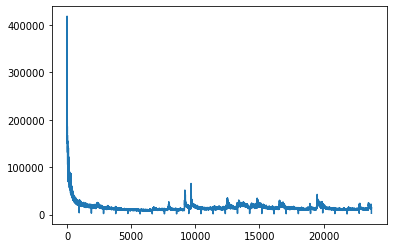

In [30]:
# loss plot
_ = plt.plot(losses)

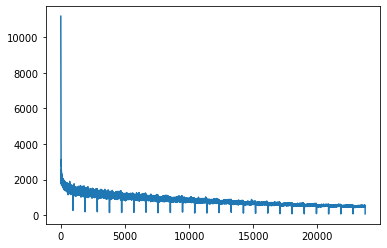

In [31]:
# caption_losses
_ = plt.plot(caption_losses)

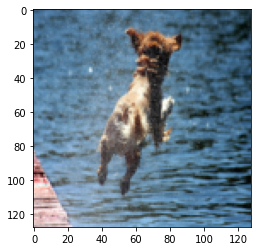

In [33]:
# reconstructed image from decoder
plt.imshow(images[1].to("cpu").permute(1, 2, 0))

In [34]:
# Saving the weights of the model
torch.save(model.state_dict(), './outputs.pt')

In [56]:
# actual captions
actual=[]
for j in range(0,2):
    actual.append(' '.join([ id_to_word.get(i) for i in captions_transformed[j].cpu().detach().numpy() if(id_to_word.get(i))!='.']))

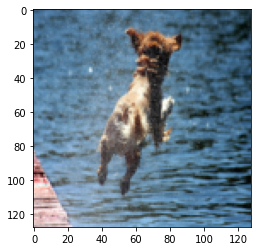

In [36]:
plt.imshow(images[1].to("cpu").permute(1, 2, 0))

In [57]:
# bLEU_SCORE
def evaluate_model(model,images):
    predicted=[]
    for i in range(0,2):
        predicted.append(get_caption(model.generate_caption(images[i].unsqueeze(0))))
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    

In [58]:
#metric evaluvation for the model
evaluate_model(model,images)

BLEU-1: 0.196850
BLEU-2: 0.443678
BLEU-3: 0.614103
BLEU-4: 0.666092


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
